## README
Author: John Wang

The below Image Processing and Computer Vison techniques are applied in this demostration:
* Custom Harris Corner Detection with different threshold values
* Applying SIFT between two images
* Image Stitching with RANSAC method

### Dev Env (Python 3.10.5)

numpy==1.26.1

opencv-python==4.9.0.80

matplotlib==3.8.2

### Imports & Setup
Image directory and image file name can be setup here

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

# Relative dir or absolute dir
LOCAL_DIR = "Images/"

## Util Functions

In [59]:
def show_images(*args, cmap=None):
    """
    Display multiple imgs with their descriptions.
    Arguments should be in the form: img1, description1, img2, description2, ...
    """
    n = len(args)
    n_images = n // 2

    # Create a subplot with n_images rows
    fig, axes = plt.subplots(n_images, 1, figsize=(10, 5*n_images))

    # In case of only one image, axes is not a list, so we make it a list
    if n_images == 1:
        axes = [axes]

    # Loop arg pairs
    for i in range(0, n, 2):
        img = args[i]
        description = args[i + 1]
        ax = axes[i // 2]

        # Show image with optional cmap val
        if cmap:
            ax.imshow(img, cmap=cmap)
        else:
            ax.imshow(img)
        ax.set_title(description)

    plt.show()

## 1.Harris Corner Detection

In [60]:
# ksize param for cv2.Sobel()
KSIZE = 15

IMG_DEPTH = cv2.CV_64F
GAUSSIAN_KERNAL_SIZE = (5,5)
CORNERNESS_K = 0.05

img_checkerboard_path = LOCAL_DIR + "checkerboard.png"
img_house_path = LOCAL_DIR + "courthouse_gray.jpg"

IMG_CHECKERBOARD = cv2.imread(img_checkerboard_path)
IMG_CHECKERBOARD_GRAY = cv2.cvtColor(IMG_CHECKERBOARD, cv2.COLOR_RGB2GRAY)
IMG_HOUSE = cv2.imread(img_house_path)
IMG_HOUSE_GRAY = cv2.cvtColor(IMG_HOUSE, cv2.COLOR_BGR2GRAY)

def harris(img_gray, img_depth=IMG_DEPTH, gauss_kernal_n=GAUSSIAN_KERNAL_SIZE, k=CORNERNESS_K):

    # Step1: Compute the image derivatives. (i.e Ix and Iy)
    img_dx = cv2.Sobel(img_gray, img_depth, 1, 0, ksize=KSIZE)
    img_dy = cv2.Sobel(img_gray, img_depth, 0, 1, ksize=KSIZE)

    # Step1.5: Find Ix*Iy (Needed later)
    img_dxdy = img_dx*img_dy

    # Step2: Compute the square of the derivatives. (i.e Ix^2 and Iy^2)
    img_dx_squre = np.square(img_dx)
    img_dy_squre = np.square(img_dy)

    # Step3: Apply Gaussian Filtering. (i.e g(Ix^2), g(Iy^2) )
    img_dx_squre_gauss = cv2.GaussianBlur(img_dx_squre, gauss_kernal_n, 1)
    img_dy_squre_gauss = cv2.GaussianBlur(img_dy_squre, gauss_kernal_n, 1)
    img_dxdy_gauss = cv2.GaussianBlur(img_dxdy, gauss_kernal_n, 1)

    def cornerness(img_Ix_squre, img_Iy_squre, img_IxIy, k=k):
        return img_Ix_squre*img_Iy_squre - np.square(img_IxIy) - k*np.square(img_Ix_squre+img_Iy_squre)


    # Step4: Cornerness Function
    img_cornerness_resp = cornerness(img_dx_squre_gauss,
                                                img_dy_squre_gauss,
                                                img_dxdy_gauss)

    # Step5: Cornerness Function
    # As discussed in the discussion board, unlike the non_maximum_suppression used in Cannay,
    # We will just Just scan through all the pixels in the cornerness image and determine 
    # if the pixel has the maximum value of all the pixels in a small window around it.
    def non_maximum_suppression(img_cornerness_resp, window_size=3):
        # Initialize an return image to store the NMS results
        nms_img = np.zeros_like(img_cornerness_resp)
        
        # Calculate the offset from the center of the window
        offset = window_size // 2
        
        # Iterate through the image excluding the border equal to the window's radius
        for y in range(offset, img_cornerness_resp.shape[0] - offset):
            for x in range(offset, img_cornerness_resp.shape[1] - offset):
                # Define the local window based on the current pixel and window_size
                local_window = img_cornerness_resp[y-offset:y+offset+1, x-offset:x+offset+1]
                
                # Check if the current pixel is the maximum within the local window
                if img_cornerness_resp[y, x] == np.max(local_window):
                    nms_img[y, x] = img_cornerness_resp[y, x]
                    
        return nms_img
    
    return non_maximum_suppression(img_cornerness_resp)

img_checkerboard_corners = harris(IMG_CHECKERBOARD_GRAY)
img_house_corners = harris(IMG_HOUSE_GRAY)



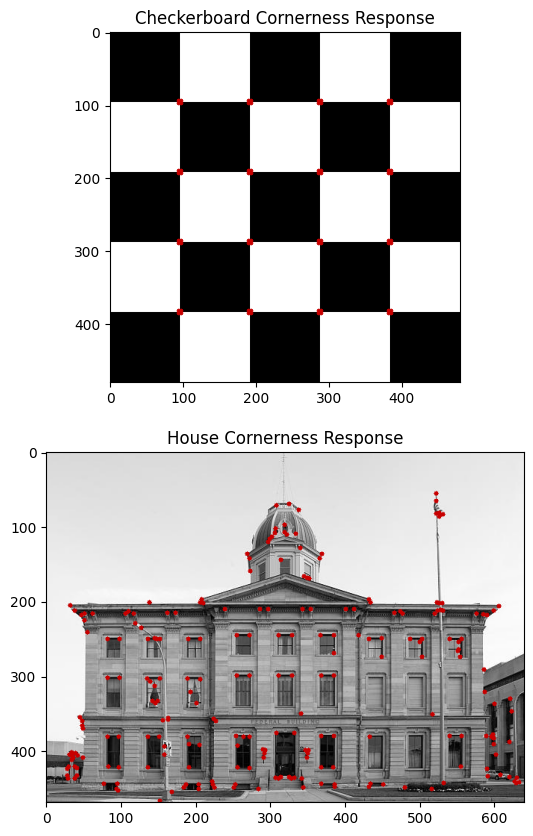

In [61]:
# Define a threadhold multiplier which will be multiplied to the max of the corner
# RERUN THE CELL ABOVE AGAIN AFTER CHANGING THIS VALUE.
THRESHOLD_MULTIPLIER = 0.05

threshold_checkerboard = img_checkerboard_corners.max() * THRESHOLD_MULTIPLIER
threshold_house = img_house_corners.max() * THRESHOLD_MULTIPLIER

# Post processing to have the corrners as red dot that overlay on top of the original image.
for y in range(img_checkerboard_corners.shape[0]):
    for x in range(img_checkerboard_corners.shape[1]):
        if img_checkerboard_corners[y,x] > threshold_checkerboard:
            cv2.circle(IMG_CHECKERBOARD, (x, y), 3, (200, 0, 0), -1)

for y in range(img_house_corners.shape[0]):
    for x in range(img_house_corners.shape[1]):
        if img_house_corners[y,x] > threshold_house:
            cv2.circle(IMG_HOUSE, (x, y), 3, (200, 0, 0), -1)

show_images(IMG_CHECKERBOARD, "Checkerboard Cornerness Response",
           IMG_HOUSE, "House Cornerness Response")

## 1.1: Observations with threathold.
For the checkerboard, all the corners appears to have the same intensity. This is as expected for this kind of uniform image with fixd patterns. So adjusting the threshold values doesn't have much effect for the image. (unless setting it to 1 and all the corners will be gone)

For the house image, reducing the thresold will result in more corners/dots on the target image, but this comes with cost of noise. I tested with different values and 0.05-0.1 works the best here to elimiate the weak corners coming from the noise.

## 2.1: SIFT Introduction
### Step1: Generate a Scale-Space Image Pyramid
This is done by constructing a scale space (using Gaussian smoothing) and finding the difference of Gaussians across different scales. It is called Scale-Space Image Pyramid because we can then take the DoGs to form a Pyramid
### Step2: Key Localization
Key points are then identified as local maxima and minima of the DoG images across scales.
### Step3: Key Elimination
Then once potential key points are found, they are refined to eliminate points that have low contrast (by using threshol) or are poorly localized along edges.
### Step4: Compute the orientation of the SIFT keypoint
In this step we determines the dominant orientation for each keypoint by examining the gradient directions in its local neighborhood. A histogram of oriented gradients is created, with each entry weighted by the gradient magnitude and a Gaussian with σ proportional to the keypoint's scale. The highest peak and any other peak within a certain percentage of the highest peak's value determine the keypoint's orientation(s), ensuring rotation invariance. This can result in multiple orientations (and thus multiple keypoints) for a single keypoint, each with consistent coordinates and scale.

## 2.2 SIFT between two different pictures

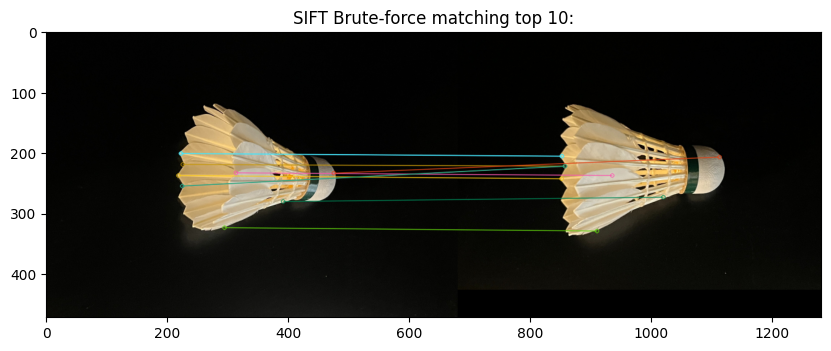

In [62]:
SIFT_BASE1_PATH = LOCAL_DIR + "Shuttle3.jpg"
SIFT_BASE2_PATH = LOCAL_DIR + "Shuttle4.jpg"

SIFT_BASE1 = cv2.imread(SIFT_BASE1_PATH)
SIFT_BASE1_RGB = cv2.cvtColor(SIFT_BASE1, cv2.COLOR_BGR2RGB)
SIFT_BASE2 = cv2.imread(SIFT_BASE2_PATH)
SIFT_BASE2_RGB = cv2.cvtColor(SIFT_BASE2, cv2.COLOR_BGR2RGB)

TOP_POINTS = 10


def match_sift_keypoints(img1, img2):
    # Detect keypoints
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    # Initialize the BF matcher
    # Note this is a brute-force match. Thus it is called BF-Matcher :)
    bf = cv2.BFMatcher()

    # Match descriptors between both images
    matches = bf.match(descriptors1, descriptors2)

    # Sort the matches based on distance (best matches first)
    matches_sorted = sorted(matches, key=lambda x: x.distance)
    return keypoints1, keypoints2, matches_sorted

key1, key2, matches = match_sift_keypoints(SIFT_BASE1_RGB, SIFT_BASE2_RGB)

# Draw the top ten matches
img_matches = cv2.drawMatches(SIFT_BASE1_RGB, key1, SIFT_BASE2_RGB, key2, matches[:TOP_POINTS], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

show_images(img_matches, f"SIFT Brute-force matching top {TOP_POINTS}:")



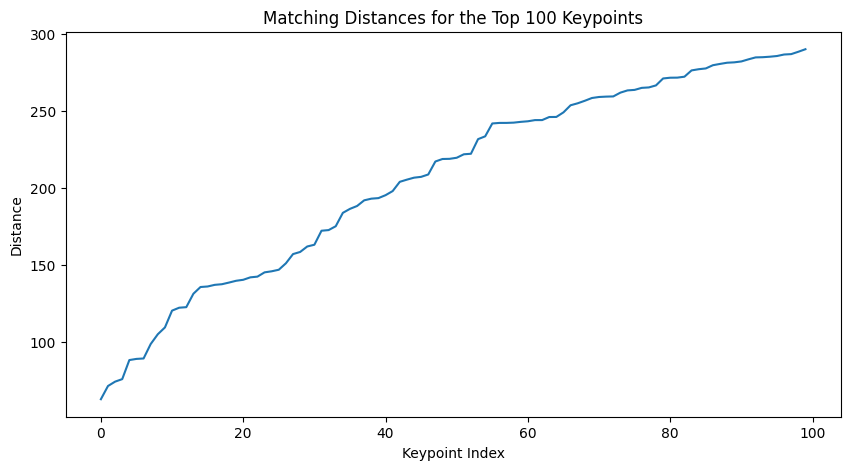

In [63]:
# Plot the matching distance for the top 100 matched keypoints
top_100_distances = [m.distance for m in matches[:100]]
plt.figure(figsize=(10, 5))
plt.plot(top_100_distances)
plt.title('Matching Distances for the Top 100 Keypoints')
plt.xlabel('Keypoint Index')
plt.ylabel('Distance')
plt.show()

## 2.3 Invariance Under Scale

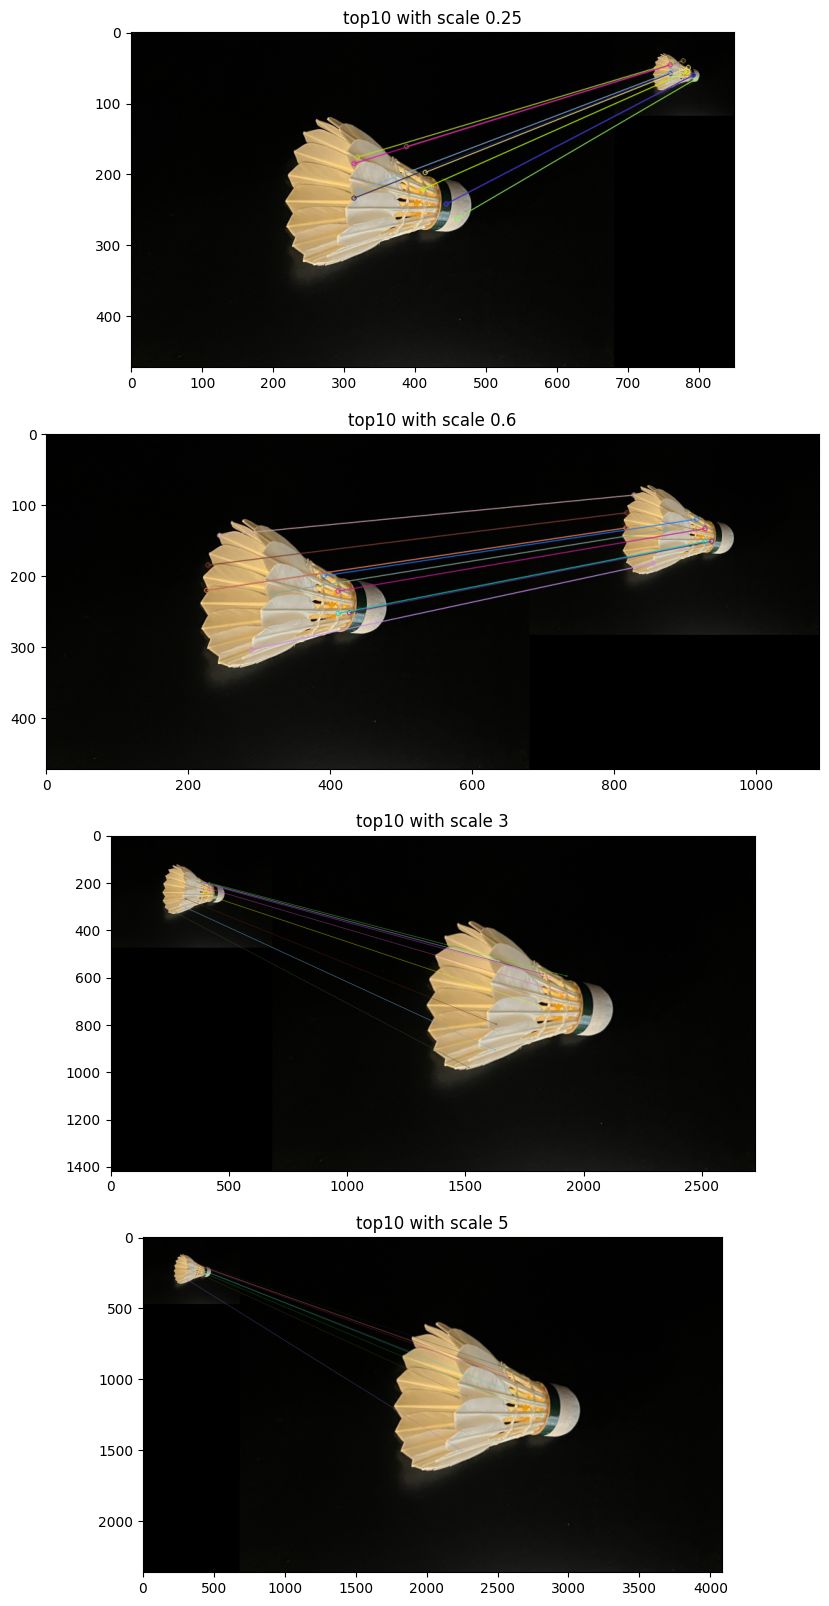

In [64]:
# Define scaling factors
SCALE = [0.25, 0.6, 3, 5]

# Scale the original image
scaled_image1 = cv2.resize(SIFT_BASE1_RGB, None, fx=SCALE[0], fy=SCALE[0])
scaled_image2 = cv2.resize(SIFT_BASE1_RGB, None, fx=SCALE[1], fy=SCALE[1])
scaled_image3 = cv2.resize(SIFT_BASE1_RGB, None, fx=SCALE[2], fy=SCALE[2])
scaled_image4 = cv2.resize(SIFT_BASE1_RGB, None, fx=SCALE[3], fy=SCALE[3])

original_key, sclaled1_key, matches1 = match_sift_keypoints(SIFT_BASE1_RGB, scaled_image1)
_, sclaled2_key, matches2 = match_sift_keypoints(SIFT_BASE1_RGB, scaled_image2)
_, sclaled3_key, matches3 = match_sift_keypoints(SIFT_BASE1_RGB, scaled_image3)
_, sclaled4_key, matches4 = match_sift_keypoints(SIFT_BASE1_RGB, scaled_image4)

img_matches1 = cv2.drawMatches(SIFT_BASE1_RGB, original_key, scaled_image1, sclaled1_key, matches1[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches2 = cv2.drawMatches(SIFT_BASE1_RGB, original_key, scaled_image2, sclaled2_key, matches2[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches3 = cv2.drawMatches(SIFT_BASE1_RGB, original_key, scaled_image3, sclaled3_key, matches3[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches4 = cv2.drawMatches(SIFT_BASE1_RGB, original_key, scaled_image4, sclaled4_key, matches4[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

show_images(img_matches1, f"top10 with scale {SCALE[0]}",
            img_matches2, f"top10 with scale {SCALE[1]}",
            img_matches3, f"top10 with scale {SCALE[2]}",
            img_matches4, f"top10 with scale {SCALE[3]}")

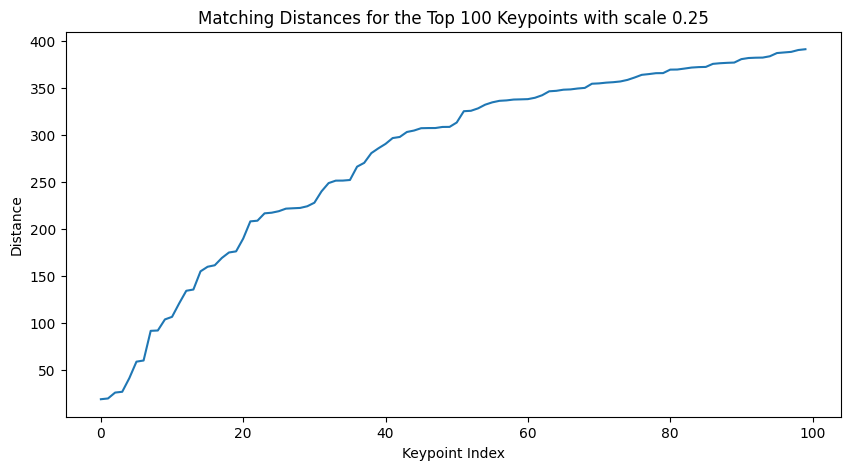

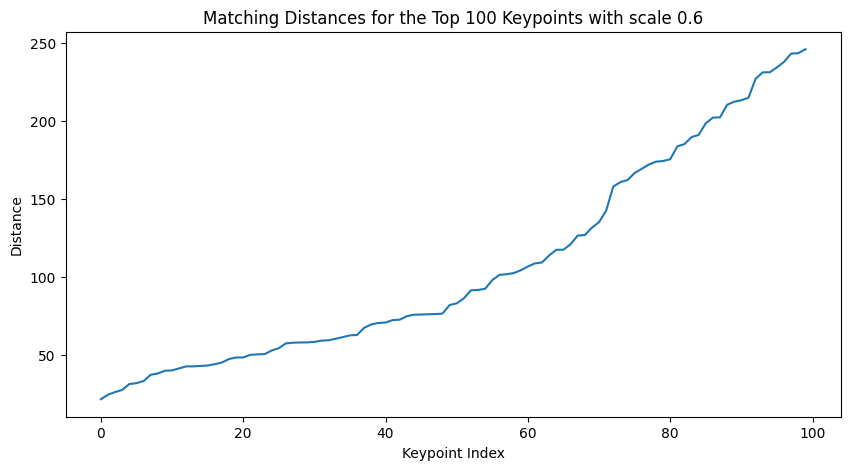

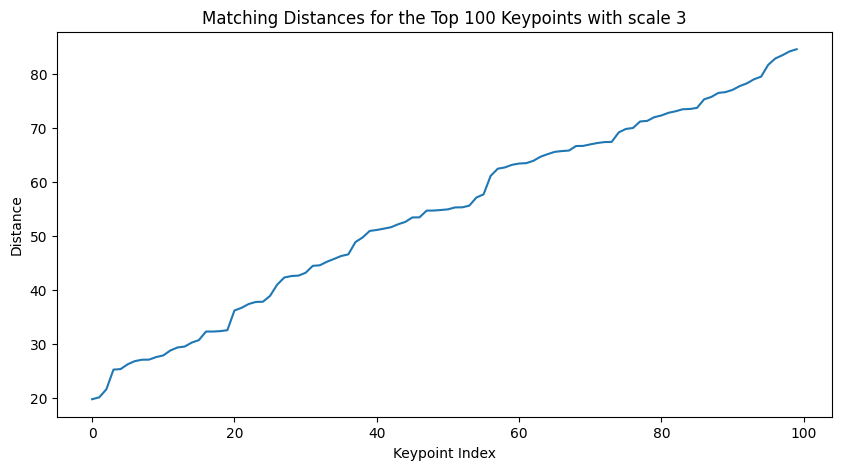

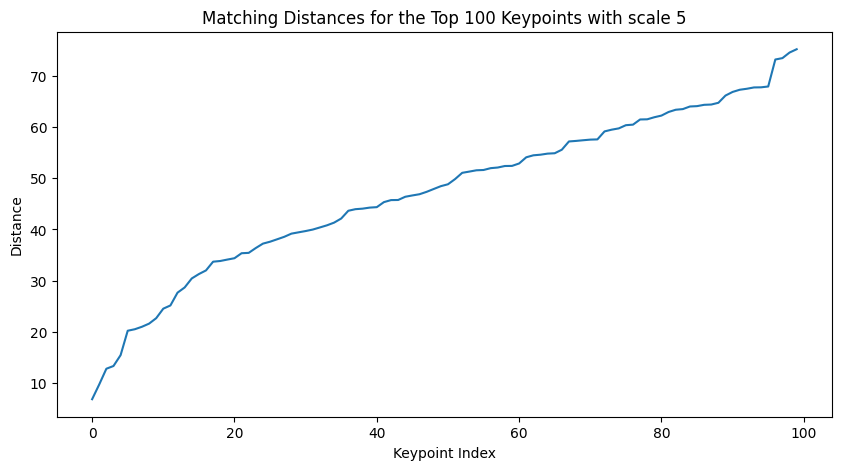

In [65]:
# Plot the matching distance for the top 100 matched keypoints
for i, matches in enumerate([matches1, matches2, matches3, matches4]):
    top_100_distances = [m.distance for m in matches[:100]]
    plt.figure(figsize=(10, 5))
    plt.plot(top_100_distances)
    plt.title(f'Matching Distances for the Top 100 Keypoints with scale {SCALE[i]}')
    plt.xlabel('Keypoint Index')
    plt.ylabel('Distance')
    plt.show()

## 2.3 Observation with top 100 distances.
I observe that the disctance is decreasing as we scale up.

In theory, the distance between corresponding keypoints in the two images should ideally not change as the SIFT is designed to be scale-invariant.

However, Looking at the top 10 distances selected, I can see thay are on didfferent part of the image. This may suggest that as we scale up in this case, the SIFT is able to find better matching features and thus reduce the top100 keypoint distance.

## 2.4: Invariance Under Rotation


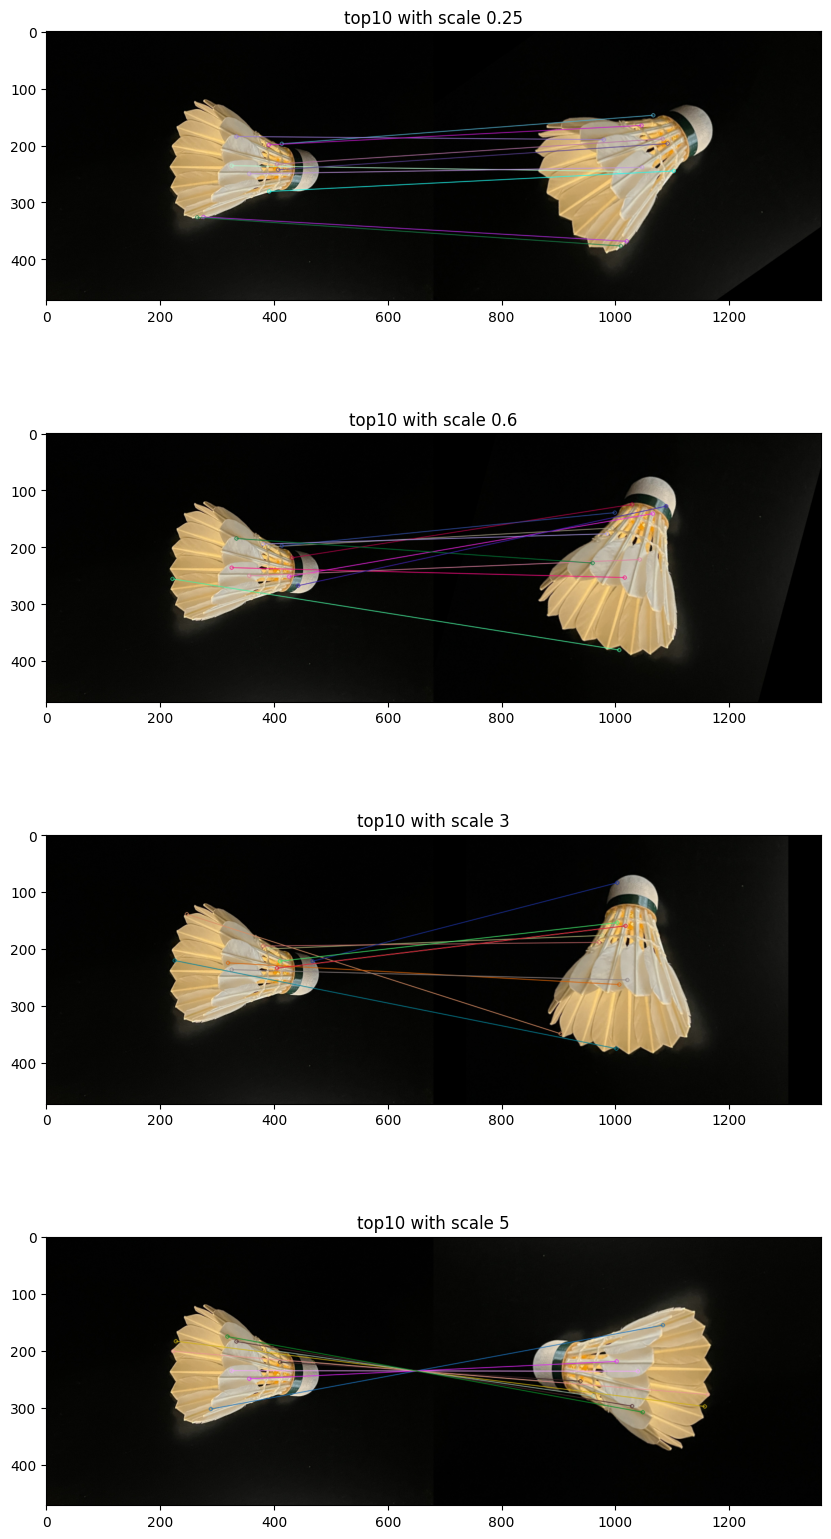

In [66]:
# Define rotating factors
ROTATION = [35, 75, 90, 180]

# Set up rotation matrix.
h, w = SIFT_BASE1.shape[:2]
M1 = cv2.getRotationMatrix2D((w/2,h/2),ROTATION[0],1.2)
M2 = cv2.getRotationMatrix2D((w/2,h/2),ROTATION[1],1.2)
M3 = cv2.getRotationMatrix2D((w/2,h/2),ROTATION[2],1.2)
M4 = cv2.getRotationMatrix2D((w/2,h/2),ROTATION[3],1.2)

# Rotate the original image
rotated_image1 = cv2.warpAffine(SIFT_BASE1_RGB, M1, (w,h))
rotated_image2 = cv2.warpAffine(SIFT_BASE1_RGB, M2, (w,h))
rotated_image3 = cv2.warpAffine(SIFT_BASE1_RGB, M3, (w,h))
rotated_image4 = cv2.warpAffine(SIFT_BASE1_RGB, M4, (w,h))

original_key, sclaled1_key, matches1_rotation = match_sift_keypoints(SIFT_BASE1_RGB, rotated_image1)
_, sclaled2_key, matches2_rotation = match_sift_keypoints(SIFT_BASE1_RGB, rotated_image2)
_, sclaled3_key, matches3_rotation = match_sift_keypoints(SIFT_BASE1_RGB, rotated_image3)
_, sclaled4_key, matches4_rotation = match_sift_keypoints(SIFT_BASE1_RGB, rotated_image4)

img_matches1_rotation = cv2.drawMatches(SIFT_BASE1_RGB, original_key, rotated_image1, sclaled1_key, matches1_rotation[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches2_rotation = cv2.drawMatches(SIFT_BASE1_RGB, original_key, rotated_image2, sclaled2_key, matches2_rotation[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches3_rotation = cv2.drawMatches(SIFT_BASE1_RGB, original_key, rotated_image3, sclaled3_key, matches3_rotation[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
img_matches4_rotation = cv2.drawMatches(SIFT_BASE1_RGB, original_key, rotated_image4, sclaled4_key, matches4_rotation[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

show_images(img_matches1_rotation, f"top10 with scale {SCALE[0]}",
            img_matches2_rotation, f"top10 with scale {SCALE[1]}",
            img_matches3_rotation, f"top10 with scale {SCALE[2]}",
            img_matches4_rotation, f"top10 with scale {SCALE[3]}")

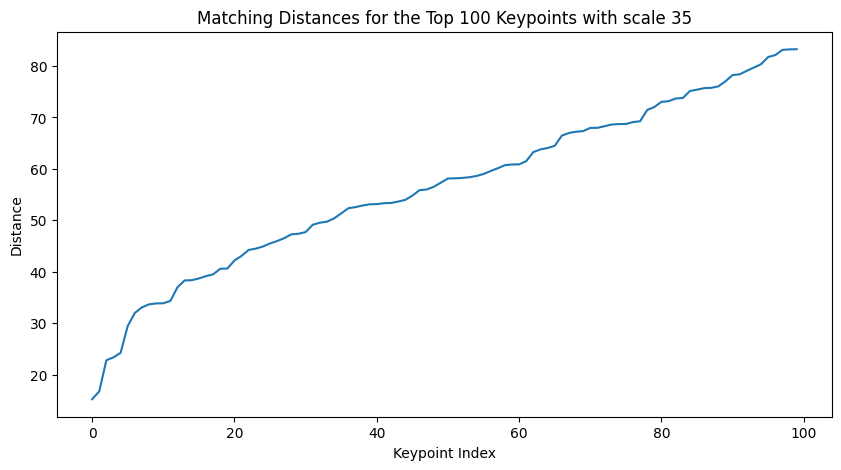

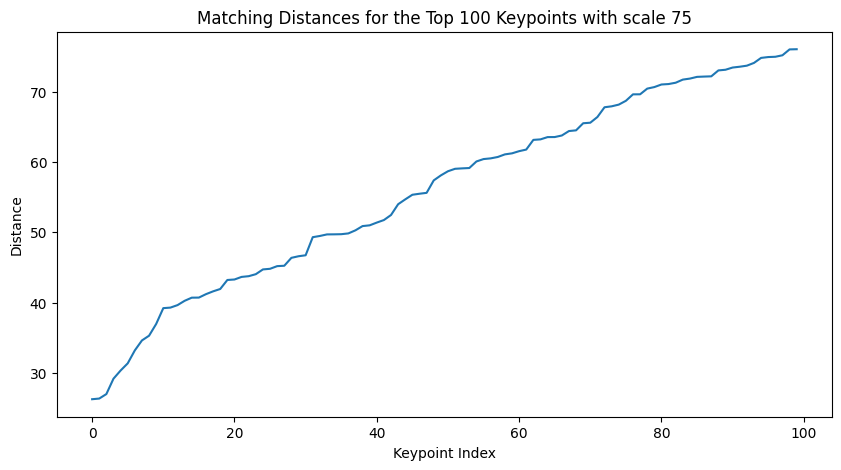

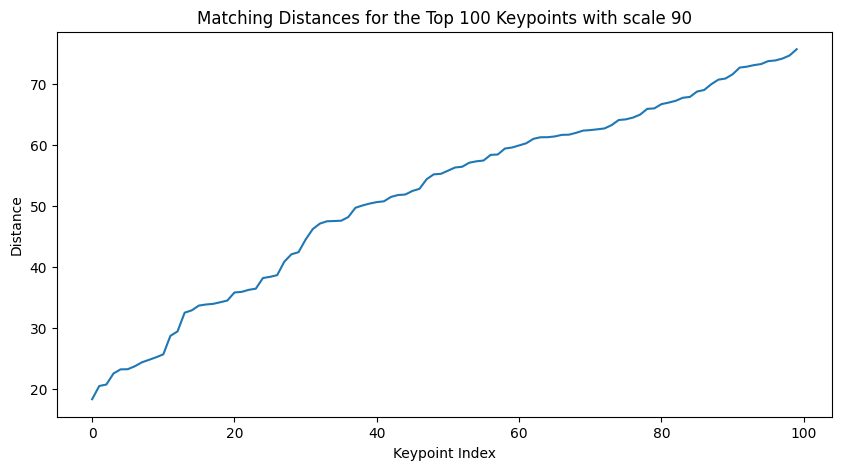

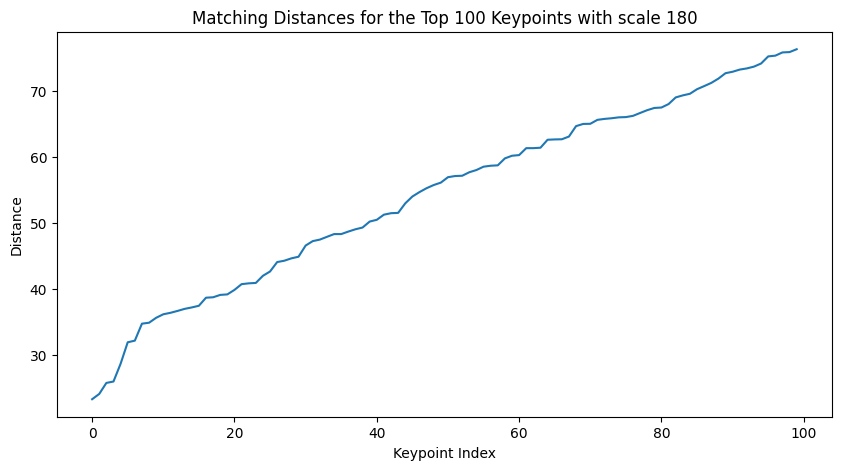

In [67]:
# Plot the matching distance for the top 100 matched keypoints
for i, matches in enumerate([matches1_rotation, matches2_rotation, matches3_rotation, matches4_rotation]):
    top_100_distances = [m.distance for m in matches[:100]]
    plt.figure(figsize=(10, 5))
    plt.plot(top_100_distances)
    plt.title(f'Matching Distances for the Top 100 Keypoints with scale {ROTATION[i]}')
    plt.xlabel('Keypoint Index')
    plt.ylabel('Distance')
    plt.show()

## 2.4 Oberservation Under Rotations
We can see the top100 keypoint distance are generally on the same level. This is as expected since SIFT is rotation-invariant. This is because during the SIFT we are computing for Image dradients and the angle histogram, and thus SIFT can utilize these infomation to rotate the descriptors (relative to the keypoint canonical orientation) to achive rotation-invariant.

## 3: Image Stitching

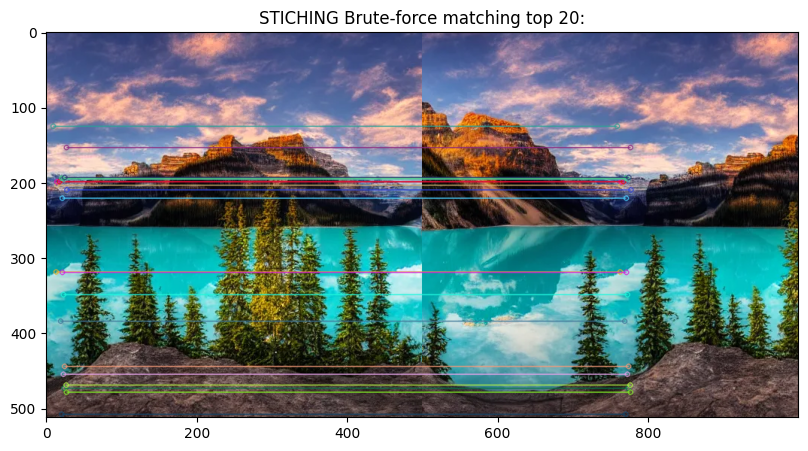

In [69]:
STICHING_BASE1_PATH = LOCAL_DIR + "part1.png"
STICHING_BASE2_PATH = LOCAL_DIR + "part2.png"
STICHING_BASE3_PATH = LOCAL_DIR + "part3.png"

STICHING_BASE1 = cv2.imread(STICHING_BASE1_PATH)
STICHING_BASE1_RGB = cv2.cvtColor(STICHING_BASE1, cv2.COLOR_BGR2RGB)
STICHING_BASE2 = cv2.imread(STICHING_BASE2_PATH)
STICHING_BASE2_RGB = cv2.cvtColor(STICHING_BASE2, cv2.COLOR_BGR2RGB)
STICHING_BASE3 = cv2.imread(STICHING_BASE3_PATH)
STICHING_BASE3_RGB = cv2.cvtColor(STICHING_BASE3, cv2.COLOR_BGR2RGB)

TOP_POINTS = 20

# Step a: Computer the keypoints
key2, key1, matches = match_sift_keypoints(STICHING_BASE2_RGB, STICHING_BASE1_RGB)
# Step b: Draw the top matches
img_matches = cv2.drawMatches(STICHING_BASE2_RGB, key2, STICHING_BASE1_RGB, key1, matches[:TOP_POINTS], None, flags=2)

show_images(img_matches, "STICHING Brute-force matching top 20:")

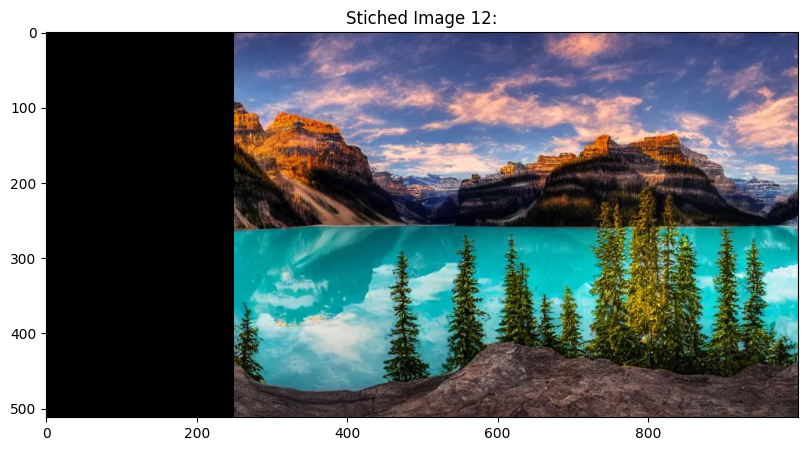

In [70]:
# The use of below logic follows the OpenCV's offical docs
# At https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html

# Extract location of top matches
src_pts = np.float32([key2[m.queryIdx].pt for m in matches[:TOP_POINTS]]).reshape(-1, 1, 2)
dst_pts = np.float32([key1[m.trainIdx].pt for m in matches[:TOP_POINTS]]).reshape(-1, 1, 2)

# Step c: find homography using RANSAC
M, _= cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

# Warp the image based on homography
height, width_1, channels = STICHING_BASE1_RGB.shape
# To achive linear image blending, we want the final resulting image to have a height that is the lowest amount the 3 images.
min_height = min(STICHING_BASE1.shape[0], STICHING_BASE2.shape[0], STICHING_BASE2.shape[0])
warped_image1 = cv2.warpPerspective(STICHING_BASE1_RGB, M, (width_1, min_height))
width_2 = STICHING_BASE2_RGB.shape[1]

# Create a new image that can fit both the warped image and the destination image
stitched_image12 = np.zeros((height, width_1+width_2, channels), dtype=np.uint8)

# Step d: Stitch the transformed image 1 and the original image 2 together
# Essentially here we are selecting all rows with :, since the height is always the same
# Then we say that we are going to place the STICHING_BASE2_RGB base image on the right starting from the width_1th column index (i.e after the warped_image1)
stitched_image12[:, width_2:] = STICHING_BASE2_RGB
# Place the warped image1 on the left
stitched_image12[:, :width_2] = warped_image1

show_images(stitched_image12, "Stiched Image 12:")

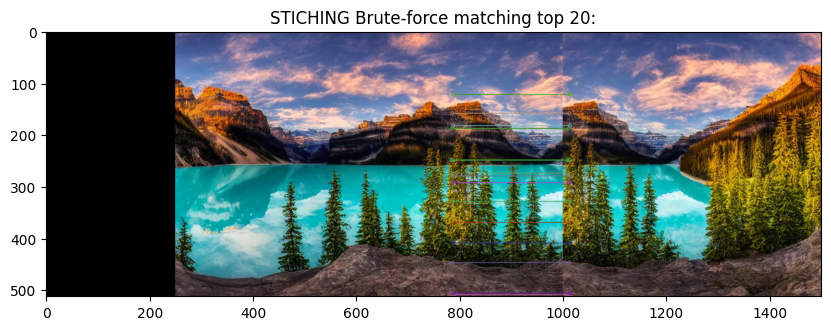

In [71]:
# Step e: Computer the keypoints
key12, key3, matches123 = match_sift_keypoints(stitched_image12, STICHING_BASE3_RGB)
# Step f: Display the top matches
img_matches = cv2.drawMatches(stitched_image12, key12, STICHING_BASE3_RGB, key3, matches123[:TOP_POINTS], None, flags=2)

show_images(img_matches, "STICHING Brute-force matching top 20:")

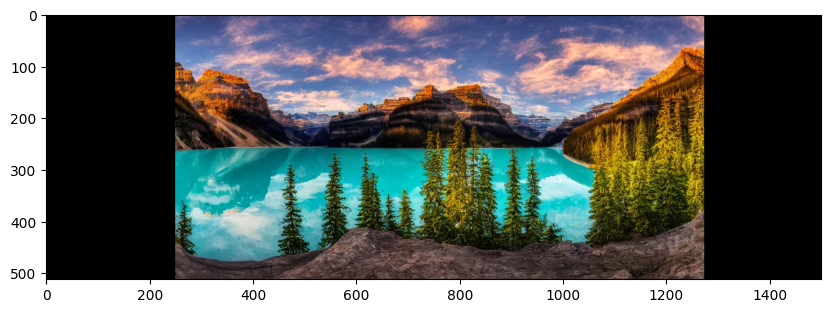

In [72]:
width_12 = stitched_image12.shape[1]
# Extract location of top matches
src_pts = np.float32([key12[m.queryIdx].pt for m in matches123[:TOP_POINTS]]).reshape(-1, 1, 2)
dst_pts = np.float32([key3[m.trainIdx].pt for m in matches123[:TOP_POINTS]]).reshape(-1, 1, 2)

# Step g: find homography using RANSAC for image 12 and 3
M, _= cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
width_123 = STICHING_BASE3_RGB.shape[1]+stitched_image12.shape[1]

# Step h: warp the Base3 image and stich it with image 12 and display the image
# Here, the wrapped img will have width equal to all images combined
stitched_image123 = cv2.warpPerspective(STICHING_BASE3_RGB, M, (width_123, min_height))
stitched_image123[:, :width_12] = stitched_image12
show_images(stitched_image123, "")

## When should one prefer pyramid blending over linear blending?

Pyramid blending is simular to the Scale-Space Image Pyramid we have learned so far. It involves creating a pyramid of downsampled images and then blending these images level by level.

So, pyramid blending will be good for when the image we are trying to merge has somewhat significant color or illumination changes at the edge of where we want to combine the image. Using pyramid blending in this case will "smooth" out the edge, making transition more natural.